### import des librairies

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.feature_selection import SelectKBest,chi2
import statsmodels
from sklearn.impute import KNNImputer
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFE,RFECV
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, validation_curve,learning_curve
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import accuracy_score, f1_score , mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler,OneHotEncoder,RobustScaler, OrdinalEncoder,PowerTransformer,PolynomialFeatures
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.svm import SVR
from scipy import spatial,stats
from scipy.stats import kstest
import folium
import warnings
warnings.filterwarnings('ignore')

## Prédiction des emissions de CO2 sans Electicity ni NaturalGas

In [148]:
new_df= df2.copy()

In [149]:
y = new_df['TotalGHGEmissions']
X = new_df.drop(['SiteEnergyUseWN(kBtu)','TotalGHGEmissions',"Electricity(kBtu)","NaturalGas(kBtu)"], axis=1)
categorical_columns = X.select_dtypes(['category','object']).columns.tolist()
numerical_columns = X.select_dtypes(['int64','float64']).columns.tolist()

In [150]:
column_transformer = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerical_columns),
        ('cat', OrdinalEncoder(), categorical_columns)
    ],
    remainder='passthrough')


In [151]:
X

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,LargestPropertyUseType,ENERGYSTARScore,SourceEUI(kBtu/sf),SteamUse(kBtu)
0,10,2016,NonResidential,Hotel/Senior Care/Housing,7,DOWNTOWN,47.61390,-122.33283,1926,1.0,11,83008,Hotel/Senior Care/Housing,27.000000,146.600006,0.0
1,28,2016,SPS-District K-12,Education,2,SOUTHEAST,47.54576,-122.26853,1961,1.0,2,56228,Education,95.000000,60.700001,0.0
2,29,2016,NonResidential,Hotel/Senior Care/Housing,4,NORTHEAST,47.65959,-122.31755,2001,1.0,6,88592,Hotel/Senior Care/Housing,84.000000,148.000000,0.0
3,31,2016,NonResidential,Other,7,DOWNTOWN,47.61500,-122.33081,1930,1.0,2,67224,Retail,65.417965,61.200001,0.0
4,34,2016,SPS-District K-12,Education,3,CENTRAL,47.62266,-122.30547,1955,1.0,1,126351,Education,65.417965,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1329,50221,2016,Nonresidential COS,Other,1,DELRIDGE,47.54067,-122.37441,1982,1.0,1,18261,Leisure,65.417965,126.000000,0.0
1330,50222,2016,Nonresidential COS,Office,2,GREATER DUWAMISH,47.56722,-122.31154,1990,1.0,1,12294,Office,46.000000,161.699997,0.0
1331,50223,2016,Nonresidential COS,Other,2,DOWNTOWN,47.59625,-122.32283,2004,1.0,1,16000,Leisure,65.417965,114.199997,0.0
1332,50225,2016,Nonresidential COS,Mixed Use Property,1,GREATER DUWAMISH,47.52832,-122.32431,1989,1.0,1,14101,Leisure,65.417965,105.300003,0.0


In [152]:
pipeline = Pipeline([
    ('column_transform', column_transformer)
])

X= pipeline.fit_transform(X)


### Passage dans PowerTransform pour plus normalisé les données afin d'améliorer notre résultat

In [153]:
pt = PowerTransformer()
X= pt.fit_transform(X)


In [154]:

X = pd.DataFrame(X, columns=numerical_columns + categorical_columns)
X

,OSEBuildingID,DataYear,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SourceEUI(kBtu/sf),SteamUse(kBtu),BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,LargestPropertyUseType
0,-1.400009,0.0,0.034520,-0.028133,-1.034142,0.05244,2.086677,0.987444,-1.546863,0.429093,-0.186844,-0.231040,-1.169739,1.224761,-0.818371,-0.760356
1,-1.398639,0.0,-1.445564,2.720835,-0.033746,0.05244,-0.106355,0.465771,1.556163,-0.832124,-0.186844,2.746108,-1.655990,-0.970059,1.777716,-1.674331
2,-1.398563,0.0,0.908314,0.595443,1.336749,0.05244,1.434264,1.061813,0.809600,0.443196,-0.186844,-0.231040,-1.169739,0.091775,1.195875,-0.760356
3,-1.398411,0.0,0.056632,0.052646,-0.926985,0.05244,-0.106355,0.722249,-0.224383,-0.822164,-0.186844,-0.231040,0.015339,1.224761,-0.818371,1.793325
4,-1.398182,0.0,0.208887,1.104696,-0.216883,0.05244,-1.214694,1.412947,-0.224383,-2.274072,-0.186844,2.746108,-1.655990,-0.389172,-1.673004,-1.674331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1329,2.557330,0.0,-1.563315,-1.604818,0.655475,0.05244,-1.214694,-1.642583,-0.224383,0.203285,-0.186844,1.781773,0.015339,-1.748768,-1.224536,-0.337346
1330,2.557411,0.0,-0.958907,0.847306,0.936199,0.05244,-1.214694,-2.254310,-0.973477,0.574208,-0.186844,1.781773,-0.156717,-0.970059,-0.085144,0.271123
1331,2.557493,0.0,-0.329146,0.376963,1.448756,0.05244,-1.214694,-1.863664,-0.224383,0.055388,-0.186844,1.781773,0.015339,-0.970059,-0.818371,-0.337346
1332,2.557655,0.0,-1.852451,0.316243,0.900606,0.05244,-1.214694,-2.059384,-0.224383,-0.067266,-0.186844,1.781773,-0.328008,-1.748768,-0.085144,-0.337346


In [155]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.25,random_state = 42)

In [156]:
X.shape

(1334, 16)

In [157]:
y.shape

(1334,)

In [158]:
print(X_train.isna().sum().sum())
print(X_test.isna().sum().sum())
print(y_train.isna().sum().sum())
print(y_test.isna().sum().sum())

0
0
0
0


### Recherche des hyper parametres

In [159]:
models = [
    ('LinearRegression', LinearRegression(), {'normalize': [True, False]}),
    ('gboost', GradientBoostingRegressor(), {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2]
    }),
    ('rfr', RandomForestRegressor(), {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }),
    ('KNeighborsRegressor', KNeighborsRegressor(), {'n_neighbors': [3, 5, 7]}),
    ('SVR', SVR(), {
        'kernel': ['linear', 'poly', 'rbf'],
        'C': [0.1, 1, 10],
        'epsilon': [0.01, 0.1, 0.2]
    }),
    ('ElasticNet', ElasticNet(), {
        'alpha': [0.01, 0.1, 1.0],
        'l1_ratio': [0.1, 0.5, 0.9],
        'normalize': [True, False]
    })
]

best_params = {}

for model_name, model, param_grid in models:
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_params[model_name] = grid_search.best_params_
best_params

{'LinearRegression': {'normalize': True},
 'gboost': {'learning_rate': 0.1, 'n_estimators': 50},
 'rfr': {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100},
 'KNeighborsRegressor': {'n_neighbors': 7},
 'SVR': {'C': 10, 'epsilon': 0.2, 'kernel': 'linear'},
 'ElasticNet': {'alpha': 0.1, 'l1_ratio': 0.9, 'normalize': False}}

### Modélisation de plusieurs modèles

In [160]:
models = [
    ('Dummy Regressor', DummyRegressor(), {'strategy' : ['mean']}),  
    ('Linear Regression', LinearRegression(), {'fit_intercept': [True, False], 'normalize': [True, False], 'copy_X': [True]}),
    ('Elastic Net', ElasticNet(), {'alpha': [1,0.1,0.01,0.001], 'max_iter': [1000], 'random_state': [42], 'tol': [0.001]}),
    ('K-Neighbors Regressor', KNeighborsRegressor(), {'n_neighbors': list(range(1,30))}),
    ('SVR', SVR(), {'gamma' : ['scale'],'epsilon' : [0.001, 0.01, 0.1, 1],'C' : [0.001, 0.01, 0.1, 1, 10], 'tol':[0.001]}),
    ('Random Forest Regressor', RandomForestRegressor(), {'n_estimators': [100, 500, 1000], 'max_features': ['auto'], 'n_jobs': [-1], 
              'random_state': [42], 'max_depth': [None]}),
    ('Gradient Boosting Regressor', GradientBoostingRegressor(), 
     {'n_estimators':[100, 500, 1000], 'random_state': [42], 'max_depth': [None]})
]


In [161]:
results = []

for model_name, model, param_grid in models:
   
    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    train_r2 = r2_score(y_train, model.predict(X_train))
    test_r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    med_abs_error= round(median_absolute_error(y_test, y_pred),2)
    elapsed_time = time.time() - start_time
    results.append([model_name, 'No CV', train_r2, test_r2, rmse, med_abs_error, elapsed_time])

   
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    train_r2 = r2_score(y_train, best_model.predict(X_train))
    test_r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    med_abs_error= round(median_absolute_error(y_test, y_pred),2)
    elapsed_time = time.time() - start_time
    results.append([model_name, 'GridSearchCV', train_r2, test_r2, rmse,med_abs_error, elapsed_time])

  
    randomized_search = RandomizedSearchCV(model, param_grid, n_iter=5, cv=5, n_jobs=-1)
    start_time = time.time()
    randomized_search.fit(X_train, y_train)
    best_model = randomized_search.best_estimator_
    y_pred = best_model.predict(X_test)
    train_r2 = r2_score(y_train, best_model.predict(X_train))
    test_r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    med_abs_error= round(median_absolute_error(y_test, y_pred),2)
    elapsed_time = time.time() - start_time
    results.append([model_name, 'RandomizedSearchCV', train_r2, test_r2, rmse,med_abs_error, elapsed_time])

results_df = pd.DataFrame(results, columns=['Model', 'CV Type', 'Train R2', 'Test R2', 'RMSE','Median absolute error',
                                            'Elapsed Time'])

results_df


,Model,CV Type,Train R2,Test R2,RMSE,Median absolute error,Elapsed Time
0,Dummy Regressor,No CV,0.000000,-0.001636,49.501962,31.02,0.002039
1,Dummy Regressor,GridSearchCV,0.000000,-0.001636,49.501962,31.02,0.012385
2,Dummy Regressor,RandomizedSearchCV,0.000000,-0.001636,49.501962,31.02,0.011322
3,Linear Regression,No CV,0.348005,0.353427,39.771895,22.32,0.005014
4,Linear Regression,GridSearchCV,0.348005,0.353427,39.771895,22.32,0.045237
5,Linear Regression,RandomizedSearchCV,0.348005,0.353427,39.771895,22.32,0.047431
6,Elastic Net,No CV,0.290517,0.285648,41.804546,24.68,0.004996
7,Elastic Net,GridSearchCV,0.347979,0.352997,39.785111,22.56,0.046028
8,Elastic Net,RandomizedSearchCV,0.347979,0.352997,39.785111,22.56,0.045783
9,K-Neighbors Regressor,No CV,0.452241,0.297037,41.469954,21.71,0.029320


In [162]:
gboost = GradientBoostingRegressor(**best_params['gboost'])
gboost.fit(X_train, y_train)

GradientBoostingRegressor(n_estimators=50)

In [163]:
print('Score train : ',round(gboost.score(X_train, y_train),3))
print('Score test  : ',round(gboost.score(X_test, y_test),3))

Score train :  0.602
Score test  :  0.372


In [164]:
rfr = RandomForestRegressor(max_depth= 20,
  min_samples_split= 10,
  n_estimators= 100)
rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, min_samples_split=10)

In [165]:
print('Score train : ',round(rfr.score(X_train, y_train),3))
print('Score test  : ',round(rfr.score(X_test, y_test),3))

Score train :  0.807
Score test  :  0.373


#### Courbe d'apprentissage du modèle Gradientboost

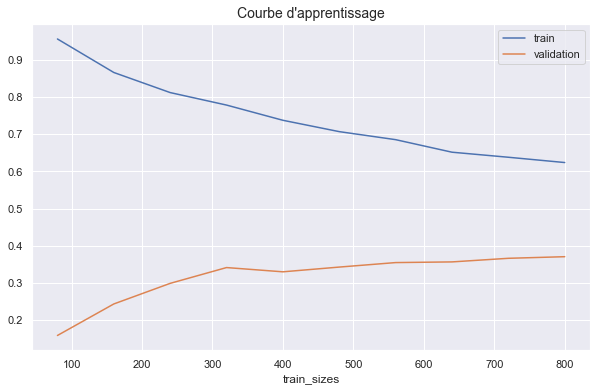

In [166]:
N,train_score,val_score = learning_curve(gboost,X_train,y_train,train_sizes = np.linspace(0.1,1.0,10))
plt.figure(figsize=(10, 6))
plt.plot(N,train_score.mean(axis=1),label='train')
plt.plot(N,val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.title("Courbe d'apprentissage", size = 14)
plt.legend()
plt.show()

#### Courbe de validation du modèle Gradientboost

In [167]:
param_range = [50, 100, 150, 200, 250]  
train_scores, test_scores = validation_curve(
    gboost,  
    X_train, y_train,
    param_name="n_estimators",  
    param_range=param_range,
    cv=5,  
    scoring="r2",  
    n_jobs=-1  
)


In [168]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


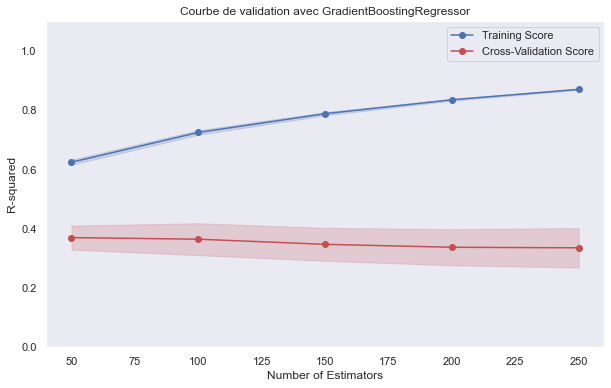

In [169]:
plt.figure(figsize=(10, 6))
plt.title("Courbe de validation avec GradientBoostingRegressor")
plt.xlabel("Number of Estimators")
plt.ylabel("R-squared")
plt.ylim(0.0, 1.1)
plt.grid()

plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="b")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="r")
plt.plot(param_range, train_scores_mean, 'o-', color="b", label="Training Score")
plt.plot(param_range, test_scores_mean, 'o-', color="r", label="Cross-Validation Score")

plt.legend(loc="best")
plt.show()


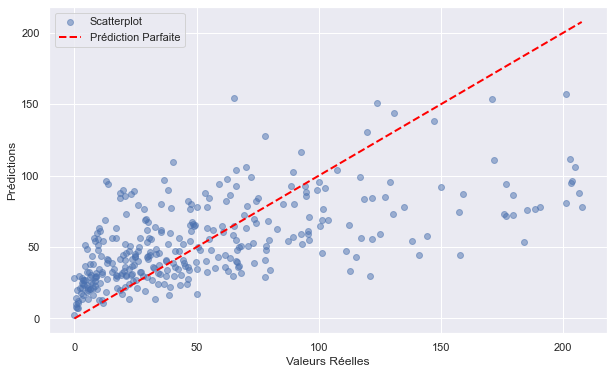

In [170]:
y_pred = gboost.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='b', label='Scatterplot')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--',
         linewidth=2, label='Prédiction Parfaite')
plt.xlabel('Valeurs Réelles')
plt.ylabel('Prédictions')
plt.legend(loc='upper left')

plt.show()


#### Courbe d'apprentissage du modèle avec RandomForest

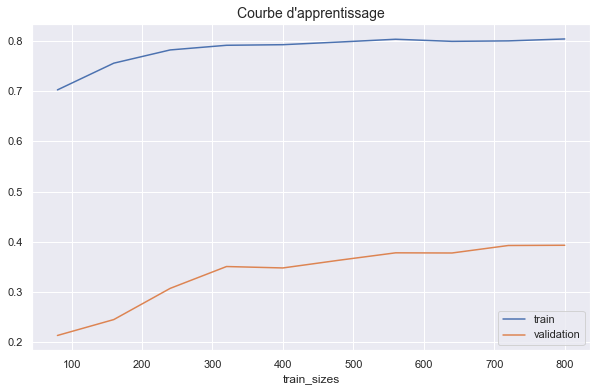

In [171]:
N,train_score,val_score = learning_curve(rfr,X_train,y_train,train_sizes =np.linspace(0.1,1.0,10))
plt.figure(figsize=(10, 6))
plt.plot(N,train_score.mean(axis=1),label='train')
plt.plot(N,val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.title("Courbe d'apprentissage", size = 14)
plt.legend()
plt.show()

#### Courbe de validation du modèle avec RandomForest

In [172]:
param_range = [50, 100, 150, 200, 250]  
train_scores, test_scores = validation_curve(
    rfr,  
    X_train, y_train,
    param_name="n_estimators",  
    param_range=param_range,
    cv=5,  
    scoring="r2",  
    n_jobs=-1  
)


In [173]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


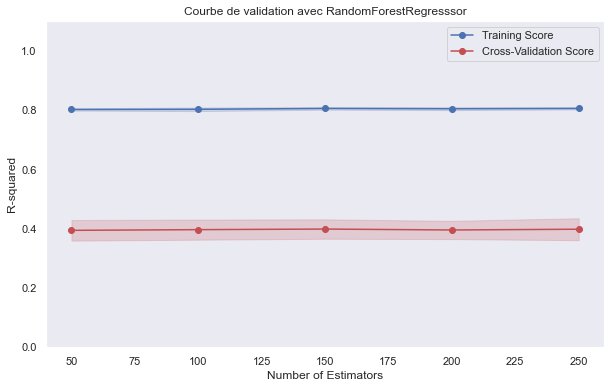

In [174]:
plt.figure(figsize=(10, 6))
plt.title("Courbe de validation avec RandomForestRegresssor")
plt.xlabel("Number of Estimators")
plt.ylabel("R-squared")
plt.ylim(0.0, 1.1)
plt.grid()

plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="b")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="r")
plt.plot(param_range, train_scores_mean, 'o-', color="b", label="Training Score")
plt.plot(param_range, test_scores_mean, 'o-', color="r", label="Cross-Validation Score")

plt.legend(loc="best")
plt.show()


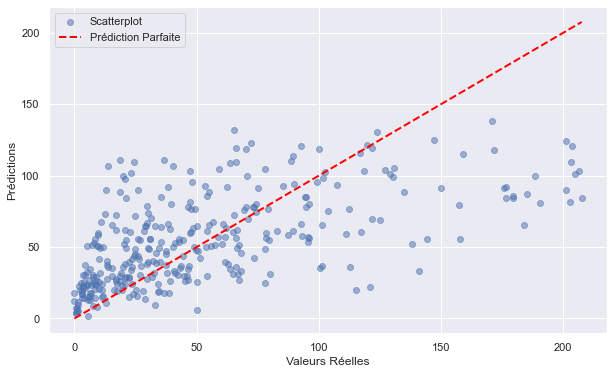

In [175]:
y_pred = rfr.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='b', label='Scatterplot')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--',
         linewidth=2, label='Prédiction Parfaite')
plt.xlabel('Valeurs Réelles')
plt.ylabel('Prédictions')
plt.legend(loc='upper left')

plt.show()


#### Features importance

In [176]:
feature_importance_rf = rfr.feature_importances_

In [177]:
feature_importance_gb = gboost.feature_importances_

In [178]:
feature_importance_rf.shape

(16,)

In [179]:
feature_importance_gb.shape

(16,)

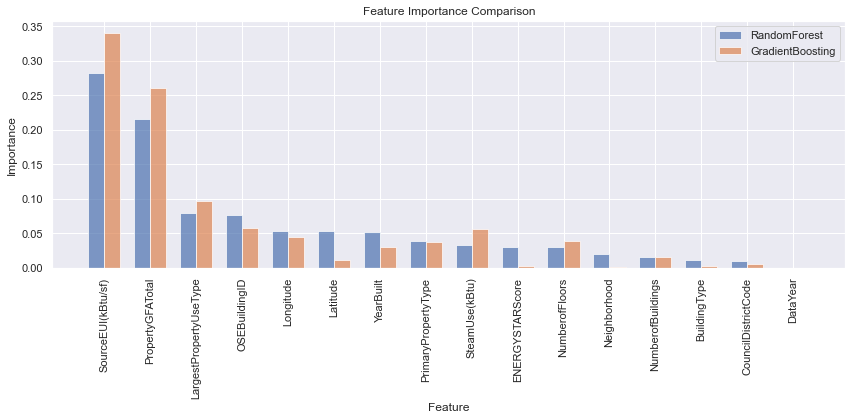

In [180]:
importance_df = pd.DataFrame({'Feature': X_train.columns, 'RandomForest': feature_importance_rf,
                              'GradientBoosting': feature_importance_gb})

importance_df.sort_values(by='RandomForest', ascending=False, inplace=True)

bar_width = 0.35
index = np.arange(len(importance_df))

plt.figure(figsize=(12, 6))
plt.bar(index, importance_df['RandomForest'], bar_width, label='RandomForest', alpha=0.7)
plt.bar(index + bar_width, importance_df['GradientBoosting'], bar_width, label='GradientBoosting', alpha=0.7)
plt.xticks(index + bar_width / 2, importance_df['Feature'], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.legend()
plt.title('Feature Importance Comparison')
plt.tight_layout()
plt.show()

In [181]:
pd.Series(gboost.feature_importances_*100, index=X_train.columns).nlargest(20)

SourceEUI(kBtu/sf)        34.123001
PropertyGFATotal          26.107599
LargestPropertyUseType     9.659879
OSEBuildingID              5.764323
SteamUse(kBtu)             5.645903
Longitude                  4.465187
NumberofFloors             3.823239
PrimaryPropertyType        3.694959
YearBuilt                  3.040508
NumberofBuildings          1.509438
Latitude                   1.038191
CouncilDistrictCode        0.525164
ENERGYSTARScore            0.246205
BuildingType               0.232073
Neighborhood               0.124332
DataYear                   0.000000
dtype: float64

In [182]:
pd.Series(rfr.feature_importances_*100, index=X_train.columns).nlargest(20)

SourceEUI(kBtu/sf)        28.289285
PropertyGFATotal          21.635864
LargestPropertyUseType     7.931510
OSEBuildingID              7.601389
Longitude                  5.310380
Latitude                   5.305590
YearBuilt                  5.114597
PrimaryPropertyType        3.830824
SteamUse(kBtu)             3.275520
ENERGYSTARScore            3.002753
NumberofFloors             2.954188
Neighborhood               1.999982
NumberofBuildings          1.591090
BuildingType               1.145876
CouncilDistrictCode        1.011152
DataYear                   0.000000
dtype: float64

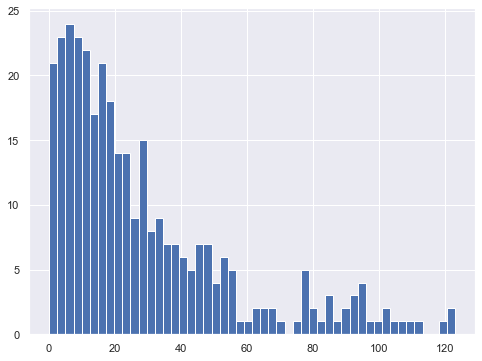

In [183]:
plt.figure(figsize=(8, 6))
y_pred = rfr.predict(X_test)
histo_erreur = np.abs(y_test - y_pred)
plt.hist(histo_erreur, bins= 50)
plt.show()

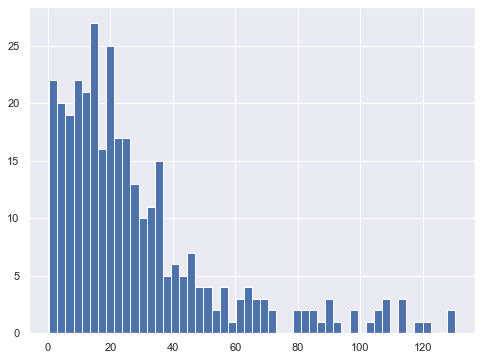

In [184]:
plt.figure(figsize=(8, 6))
y_pred = gboost.predict(X_test)
histo_erreur = np.abs(y_test - y_pred)
plt.hist(histo_erreur, bins= 50)
plt.show()

## Prédiction des émissions de CO2 en laissant l'électricité et le gas dans les données 

In [185]:
new_df= df2.copy()

In [186]:
y = new_df['TotalGHGEmissions']
X = new_df.drop(['SiteEnergyUseWN(kBtu)','TotalGHGEmissions'], axis=1)
categorical_columns = X.select_dtypes(['category','object']).columns.tolist()
numerical_columns = X.select_dtypes(['int64','float64']).columns.tolist()

In [187]:

column_transformer = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerical_columns),
        ('cat', OrdinalEncoder(), categorical_columns)
    ],
    remainder='passthrough')


In [188]:
pipeline = Pipeline([
    ('column_transform', column_transformer)
])

X= pipeline.fit_transform(X)


In [189]:
pt = PowerTransformer()
X= pt.fit_transform(X)

In [190]:
X = pd.DataFrame(X, columns=numerical_columns + categorical_columns)

In [191]:
X

,OSEBuildingID,DataYear,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SourceEUI(kBtu/sf),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,LargestPropertyUseType
0,-1.400009,0.0,0.034520,-0.028133,-1.034142,0.05244,2.086677,0.987444,-1.546863,0.429093,-0.186844,0.859387,1.794881,-0.231040,-1.169739,1.224761,-0.818371,-0.760356
1,-1.398639,0.0,-1.445564,2.720835,-0.033746,0.05244,-0.106355,0.465771,1.556163,-0.832124,-0.186844,-0.351736,0.416483,2.746108,-1.655990,-0.970059,1.777716,-1.674331
2,-1.398563,0.0,0.908314,0.595443,1.336749,0.05244,1.434264,1.061813,0.809600,0.443196,-0.186844,0.636234,1.193831,-0.231040,-1.169739,0.091775,1.195875,-0.760356
3,-1.398411,0.0,0.056632,0.052646,-0.926985,0.05244,-0.106355,0.722249,-0.224383,-0.822164,-0.186844,0.026969,-1.105483,-0.231040,0.015339,1.224761,-0.818371,1.793325
4,-1.398182,0.0,0.208887,1.104696,-0.216883,0.05244,-1.214694,1.412947,-0.224383,-2.274072,-0.186844,-1.849236,-1.105483,2.746108,-1.655990,-0.389172,-1.673004,-1.674331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1329,2.557330,0.0,-1.563315,-1.604818,0.655475,0.05244,-1.214694,-1.642583,-0.224383,0.203285,-0.186844,-0.747522,-0.168255,1.781773,0.015339,-1.748768,-1.224536,-0.337346
1330,2.557411,0.0,-0.958907,0.847306,0.936199,0.05244,-1.214694,-2.254310,-0.973477,0.574208,-0.186844,-0.908156,-0.106240,1.781773,-0.156717,-0.970059,-0.085144,0.271123
1331,2.557493,0.0,-0.329146,0.376963,1.448756,0.05244,-1.214694,-1.863664,-0.224383,0.055388,-0.186844,-1.112229,0.339979,1.781773,0.015339,-0.970059,-0.818371,-0.337346
1332,2.557655,0.0,-1.852451,0.316243,0.900606,0.05244,-1.214694,-2.059384,-0.224383,-0.067266,-0.186844,-1.192454,-0.004060,1.781773,-0.328008,-1.748768,-0.085144,-0.337346


In [192]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.25,random_state = 42)

###  Recherche des hyper paramètres

In [193]:
models = [
    ('LinearRegression', LinearRegression(), {'normalize': [True, False]}),
    ('gboost', GradientBoostingRegressor(), {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2]
    }),
    ('rfr', RandomForestRegressor(), {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }),
    ('KNeighborsRegressor', KNeighborsRegressor(), {'n_neighbors': [3, 5, 7]}),
    ('SVR', SVR(), {
        'kernel': ['linear', 'poly', 'rbf'],
        'C': [0.1, 1, 10],
        'epsilon': [0.01, 0.1, 0.2]
    }),
    ('ElasticNet', ElasticNet(), {
        'alpha': [0.01, 0.1, 1.0],
        'l1_ratio': [0.1, 0.5, 0.9],
        'normalize': [True, False]
    })
]

best_params = {}

for model_name, model, param_grid in models:
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_params[model_name] = grid_search.best_params_
best_params

{'LinearRegression': {'normalize': True},
 'gboost': {'learning_rate': 0.2, 'n_estimators': 50},
 'rfr': {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100},
 'KNeighborsRegressor': {'n_neighbors': 7},
 'SVR': {'C': 10, 'epsilon': 0.1, 'kernel': 'linear'},
 'ElasticNet': {'alpha': 0.1, 'l1_ratio': 0.9, 'normalize': False}}

In [194]:
models = [
    ('Dummy Regressor', DummyRegressor(), {'strategy' : ['mean']}),  
    ('Linear Regression', LinearRegression(), {'fit_intercept': [True, False], 'normalize': [True, False], 'copy_X': [True]}),
    ('Elastic Net', ElasticNet(), {'alpha': [1,0.1,0.01,0.001], 'max_iter': [1000], 'random_state': [42], 'tol': [0.001]}),
    ('K-Neighbors Regressor', KNeighborsRegressor(), {'n_neighbors': list(range(1,30))}),
    ('SVR', SVR(), {'gamma' : ['scale'],'epsilon' : [0.001, 0.01, 0.1, 1],'C' : [0.001, 0.01, 0.1, 1, 10], 'tol':[0.001]}),
    ('Random Forest Regressor', RandomForestRegressor(), {'n_estimators': [100, 500, 1000], 'max_features': ['auto'], 'n_jobs': [-1], 
              'random_state': [42], 'max_depth': [None]}),
    ('Gradient Boosting Regressor', GradientBoostingRegressor(), 
     {'n_estimators':[100, 500, 1000], 'random_state': [42], 'max_depth': [None]})
]


In [195]:
results = []

for model_name, model, param_grid in models:
   
    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    train_r2 = r2_score(y_train, model.predict(X_train))
    test_r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    med_abs_error= round(median_absolute_error(y_test, y_pred),2)
    elapsed_time = time.time() - start_time
    results.append([model_name, 'No CV', train_r2, test_r2, rmse, med_abs_error, elapsed_time])

   
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    train_r2 = r2_score(y_train, best_model.predict(X_train))
    test_r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    med_abs_error= round(median_absolute_error(y_test, y_pred),2)
    elapsed_time = time.time() - start_time
    results.append([model_name, 'GridSearchCV', train_r2, test_r2, rmse,med_abs_error, elapsed_time])

  
    randomized_search = RandomizedSearchCV(model, param_grid, n_iter=5, cv=5, n_jobs=-1)
    start_time = time.time()
    randomized_search.fit(X_train, y_train)
    best_model = randomized_search.best_estimator_
    y_pred = best_model.predict(X_test)
    train_r2 = r2_score(y_train, best_model.predict(X_train))
    test_r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    med_abs_error= round(median_absolute_error(y_test, y_pred),2)
    elapsed_time = time.time() - start_time
    results.append([model_name, 'RandomizedSearchCV', train_r2, test_r2, rmse,med_abs_error, elapsed_time])

results_df = pd.DataFrame(results, columns=['Model', 'CV Type', 'Train R2', 'Test R2', 'RMSE','Median absolute error',
                                            'Elapsed Time'])

results_df


,Model,CV Type,Train R2,Test R2,RMSE,Median absolute error,Elapsed Time
0,Dummy Regressor,No CV,0.000000,-0.001636,49.501962,31.02,0.001999
1,Dummy Regressor,GridSearchCV,0.000000,-0.001636,49.501962,31.02,0.012016
2,Dummy Regressor,RandomizedSearchCV,0.000000,-0.001636,49.501962,31.02,0.012117
3,Linear Regression,No CV,0.805540,0.817542,21.127564,12.41,0.005008
4,Linear Regression,GridSearchCV,0.805540,0.817542,21.127564,12.41,0.043716
5,Linear Regression,RandomizedSearchCV,0.805540,0.817542,21.127564,12.41,0.046203
6,Elastic Net,No CV,0.724405,0.724599,25.956746,12.96,0.006191
7,Elastic Net,GridSearchCV,0.805515,0.817052,21.155892,12.40,0.047243
8,Elastic Net,RandomizedSearchCV,0.805515,0.817052,21.155892,12.40,0.046997
9,K-Neighbors Regressor,No CV,0.759053,0.651408,29.202914,10.30,0.031003


In [196]:
gboost = GradientBoostingRegressor(**best_params['gboost'])
gboost.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.2, n_estimators=50)

In [197]:
print('Score train : ',round(gboost.score(X_train, y_train),3))
print('Score test  : ',round(gboost.score(X_test, y_test),3))

Score train :  0.993
Score test  :  0.96


In [198]:
rfr = RandomForestRegressor(**best_params['rfr'])
rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=10)

In [199]:
print('Score train : ',round(rfr.score(X_train, y_train),3))
print('Score test  : ',round(rfr.score(X_test, y_test),3))

Score train :  0.994
Score test  :  0.94


#### Courbe d'apprentissage du modèle Gradientboost

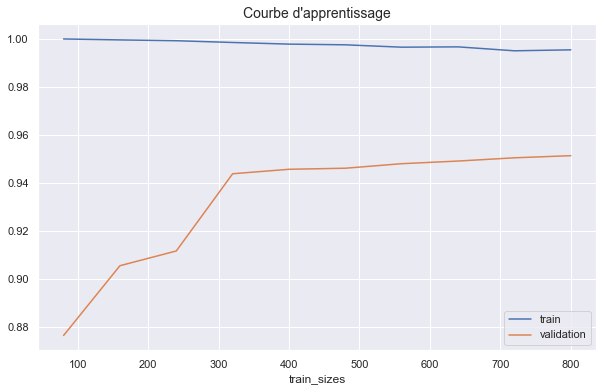

In [200]:
N,train_score,val_score = learning_curve(gboost,X_train,y_train,train_sizes = np.linspace(0.1,1.0,10))
plt.figure(figsize=(10, 6))
plt.plot(N,train_score.mean(axis=1),label='train')
plt.plot(N,val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.title("Courbe d'apprentissage", size = 14)
plt.legend()
plt.show()

#### Courbe de validation du modèle Gradientboost

In [201]:
param_range = [50, 100, 150, 200, 250]  
train_scores, test_scores = validation_curve(
    gboost,  
    X_train, y_train,
    param_name="n_estimators",  
    param_range=param_range,
    cv=5,  
    scoring="r2",  
    n_jobs=-1  
)


In [202]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


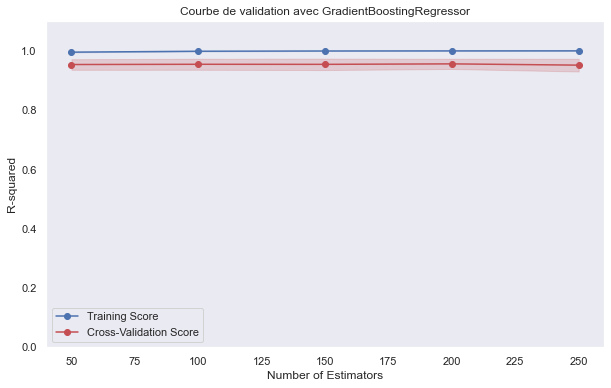

In [203]:
plt.figure(figsize=(10, 6))
plt.title("Courbe de validation avec GradientBoostingRegressor")
plt.xlabel("Number of Estimators")
plt.ylabel("R-squared")
plt.ylim(0.0, 1.1)
plt.grid()

plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="b")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="r")
plt.plot(param_range, train_scores_mean, 'o-', color="b", label="Training Score")
plt.plot(param_range, test_scores_mean, 'o-', color="r", label="Cross-Validation Score")

plt.legend(loc="best")
plt.show()


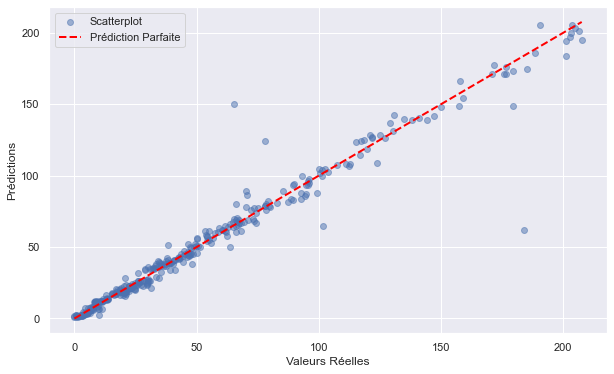

In [204]:
y_pred = gboost.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='b', label='Scatterplot')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--',
         linewidth=2, label='Prédiction Parfaite')
plt.xlabel('Valeurs Réelles')
plt.ylabel('Prédictions')
plt.legend(loc='upper left')

plt.show()


#### Courbe d'apprentissage du modèle avec RandomForest

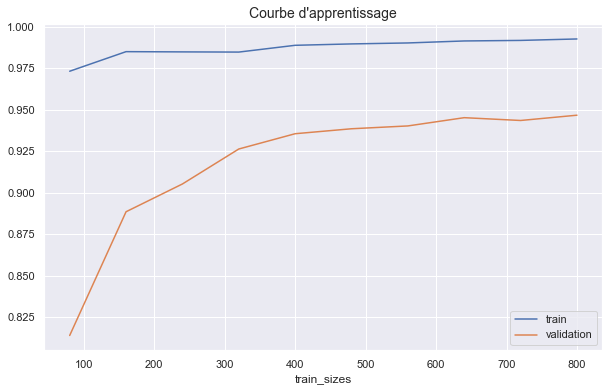

In [205]:
N,train_score,val_score = learning_curve(rfr,X_train,y_train,train_sizes =np.linspace(0.1,1.0,10))
plt.figure(figsize=(10, 6))
plt.plot(N,train_score.mean(axis=1),label='train')
plt.plot(N,val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.title("Courbe d'apprentissage", size = 14)
plt.legend()
plt.show()

#### Courbe de validation du modèle avec RandomForest

In [206]:
param_range = [50, 100, 150, 200, 250]  
train_scores, test_scores = validation_curve(
    rfr,  
    X_train, y_train,
    param_name="n_estimators",  
    param_range=param_range,
    cv=5,  
    scoring="r2",  
    n_jobs=-1  
)


In [207]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


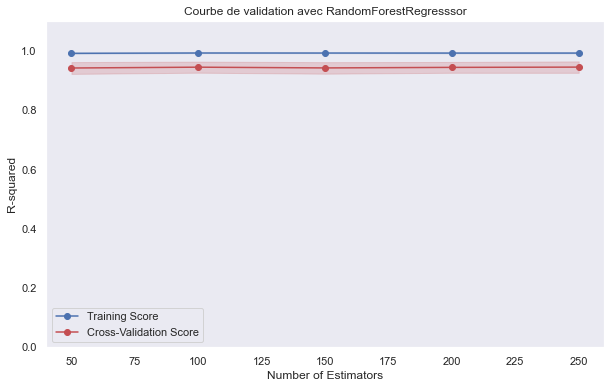

In [208]:
plt.figure(figsize=(10, 6))
plt.title("Courbe de validation avec RandomForestRegresssor")
plt.xlabel("Number of Estimators")
plt.ylabel("R-squared")
plt.ylim(0.0, 1.1)
plt.grid()

plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="b")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="r")
plt.plot(param_range, train_scores_mean, 'o-', color="b", label="Training Score")
plt.plot(param_range, test_scores_mean, 'o-', color="r", label="Cross-Validation Score")

plt.legend(loc="best")
plt.show()


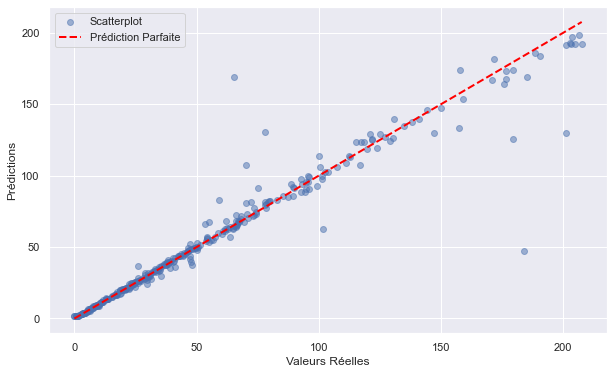

In [209]:
y_pred = rfr.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='b', label='Scatterplot')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--',
         linewidth=2, label='Prédiction Parfaite')
plt.xlabel('Valeurs Réelles')
plt.ylabel('Prédictions')
plt.legend(loc='upper left')

plt.show()


#### Features importance

In [210]:
feature_importance_rf = rfr.feature_importances_

In [211]:
feature_importance_gb = gboost.feature_importances_

In [212]:
feature_importance_rf.shape

(18,)

In [213]:
feature_importance_gb.shape

(18,)

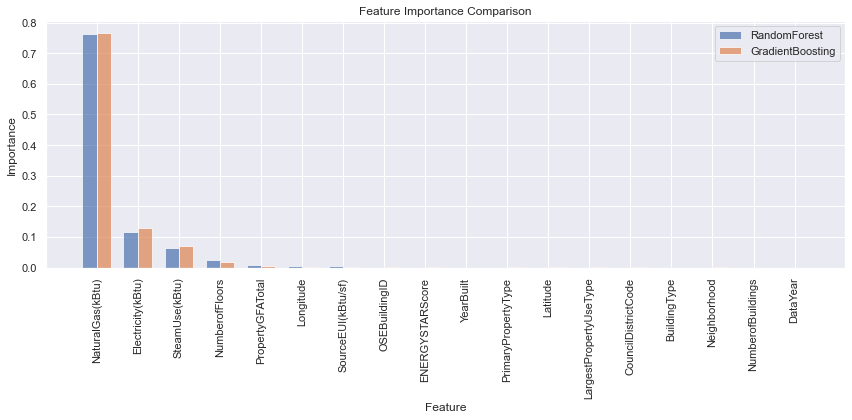

In [214]:
importance_df = pd.DataFrame({'Feature': X_train.columns, 'RandomForest': feature_importance_rf,
                              'GradientBoosting': feature_importance_gb})

importance_df.sort_values(by='RandomForest', ascending=False, inplace=True)

bar_width = 0.35
index = np.arange(len(importance_df))

plt.figure(figsize=(12, 6))
plt.bar(index, importance_df['RandomForest'], bar_width, label='RandomForest', alpha=0.7)
plt.bar(index + bar_width, importance_df['GradientBoosting'], bar_width, label='GradientBoosting', alpha=0.7)
plt.xticks(index + bar_width / 2, importance_df['Feature'], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.legend()
plt.title('Feature Importance Comparison')
plt.tight_layout()
plt.show()

In [215]:
pd.Series(gboost.feature_importances_*100, index=X_train.columns).nlargest(20)

NaturalGas(kBtu)          76.780056
Electricity(kBtu)         12.989392
SteamUse(kBtu)             7.149544
NumberofFloors             1.730097
PropertyGFATotal           0.455993
SourceEUI(kBtu/sf)         0.267891
Longitude                  0.245104
LargestPropertyUseType     0.142619
ENERGYSTARScore            0.083878
OSEBuildingID              0.043849
Latitude                   0.031439
PrimaryPropertyType        0.030835
CouncilDistrictCode        0.018761
Neighborhood               0.018396
YearBuilt                  0.012145
DataYear                   0.000000
NumberofBuildings          0.000000
BuildingType               0.000000
dtype: float64

In [216]:
pd.Series(rfr.feature_importances_*100, index=X_train.columns).nlargest(20)

NaturalGas(kBtu)          76.441067
Electricity(kBtu)         11.569403
SteamUse(kBtu)             6.323757
NumberofFloors             2.376951
PropertyGFATotal           0.819346
Longitude                  0.425304
SourceEUI(kBtu/sf)         0.351429
OSEBuildingID              0.318601
ENERGYSTARScore            0.294825
YearBuilt                  0.239616
PrimaryPropertyType        0.225256
Latitude                   0.219605
LargestPropertyUseType     0.197304
CouncilDistrictCode        0.089033
BuildingType               0.052904
Neighborhood               0.052086
NumberofBuildings          0.003514
DataYear                   0.000000
dtype: float64

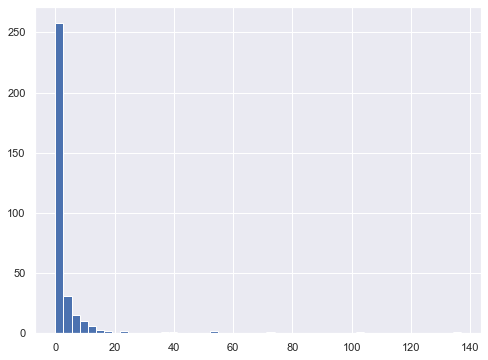

In [217]:
plt.figure(figsize=(8, 6))
y_pred = rfr.predict(X_test)
histo_erreur = np.abs(y_test - y_pred)
plt.hist(histo_erreur, bins= 50)
plt.show()

## Prédiction des émissions de CO2 sans avoir Energyscore dans les données

### Modélisation de plusieurs modèles

In [218]:
new_df = df2.copy()

In [219]:
y = new_df['TotalGHGEmissions']
X = new_df.drop(['SiteEnergyUseWN(kBtu)','TotalGHGEmissions','ENERGYSTARScore'], axis=1)
categorical_columns = X.select_dtypes(['category','object']).columns.tolist()
numerical_columns = X.select_dtypes(['int64','float64']).columns.tolist()

In [220]:

column_transformer = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerical_columns),
        ('cat', OrdinalEncoder(), categorical_columns)
    ],
    remainder='passthrough')


In [221]:
pipeline = Pipeline([
    ('column_transform', column_transformer)
])

X= pipeline.fit_transform(X)


### Passage dans PowerTransform pour plus normalisé les données afin d'améliorer notre résultat

In [222]:
pt = PowerTransformer()
X= pt.fit_transform(X)


In [223]:

X = pd.DataFrame(X, columns=numerical_columns + categorical_columns)
X

,OSEBuildingID,DataYear,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,SourceEUI(kBtu/sf),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,LargestPropertyUseType
0,-1.400009,0.0,0.034520,-0.028133,-1.034142,0.05244,2.086677,0.987444,0.429093,-0.186844,0.859387,1.794881,-0.231040,-1.169739,1.224761,-0.818371,-0.760356
1,-1.398639,0.0,-1.445564,2.720835,-0.033746,0.05244,-0.106355,0.465771,-0.832124,-0.186844,-0.351736,0.416483,2.746108,-1.655990,-0.970059,1.777716,-1.674331
2,-1.398563,0.0,0.908314,0.595443,1.336749,0.05244,1.434264,1.061813,0.443196,-0.186844,0.636234,1.193831,-0.231040,-1.169739,0.091775,1.195875,-0.760356
3,-1.398411,0.0,0.056632,0.052646,-0.926985,0.05244,-0.106355,0.722249,-0.822164,-0.186844,0.026969,-1.105483,-0.231040,0.015339,1.224761,-0.818371,1.793325
4,-1.398182,0.0,0.208887,1.104696,-0.216883,0.05244,-1.214694,1.412947,-2.274072,-0.186844,-1.849236,-1.105483,2.746108,-1.655990,-0.389172,-1.673004,-1.674331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1329,2.557330,0.0,-1.563315,-1.604818,0.655475,0.05244,-1.214694,-1.642583,0.203285,-0.186844,-0.747522,-0.168255,1.781773,0.015339,-1.748768,-1.224536,-0.337346
1330,2.557411,0.0,-0.958907,0.847306,0.936199,0.05244,-1.214694,-2.254310,0.574208,-0.186844,-0.908156,-0.106240,1.781773,-0.156717,-0.970059,-0.085144,0.271123
1331,2.557493,0.0,-0.329146,0.376963,1.448756,0.05244,-1.214694,-1.863664,0.055388,-0.186844,-1.112229,0.339979,1.781773,0.015339,-0.970059,-0.818371,-0.337346
1332,2.557655,0.0,-1.852451,0.316243,0.900606,0.05244,-1.214694,-2.059384,-0.067266,-0.186844,-1.192454,-0.004060,1.781773,-0.328008,-1.748768,-0.085144,-0.337346


In [224]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.25,random_state = 42)

### Recherche des hyper parametres

In [225]:
models = [
    ('LinearRegression', LinearRegression(), {'normalize': [True, False]}),
    ('gboost', GradientBoostingRegressor(), {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2]
    }),
    ('rfr', RandomForestRegressor(), {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }),
    ('KNeighborsRegressor', KNeighborsRegressor(), {'n_neighbors': [3, 5, 7]}),
    ('SVR', SVR(), {
        'kernel': ['linear', 'poly', 'rbf'],
        'C': [0.1, 1, 10],
        'epsilon': [0.01, 0.1, 0.2]
    }),
    ('ElasticNet', ElasticNet(), {
        'alpha': [0.01, 0.1, 1.0],
        'l1_ratio': [0.1, 0.5, 0.9],
        'normalize': [True, False]
    })
]

best_params = {}

for model_name, model, param_grid in models:
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_params[model_name] = grid_search.best_params_
best_params

{'LinearRegression': {'normalize': True},
 'gboost': {'learning_rate': 0.1, 'n_estimators': 200},
 'rfr': {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100},
 'KNeighborsRegressor': {'n_neighbors': 7},
 'SVR': {'C': 10, 'epsilon': 0.1, 'kernel': 'linear'},
 'ElasticNet': {'alpha': 0.1, 'l1_ratio': 0.9, 'normalize': False}}

In [226]:
models = [
    ('Dummy Regressor', DummyRegressor(), {'strategy' : ['mean']}),  
    ('Linear Regression', LinearRegression(), {'fit_intercept': [True, False], 'normalize': [True, False], 'copy_X': [True]}),
    ('Elastic Net', ElasticNet(), {'alpha': [1,0.1,0.01,0.001], 'max_iter': [1000], 'random_state': [42], 'tol': [0.001]}),
    ('K-Neighbors Regressor', KNeighborsRegressor(), {'n_neighbors': list(range(1,30))}),
    ('SVR', SVR(), {'gamma' : ['scale'],'epsilon' : [0.001, 0.01, 0.1, 1],'C' : [0.001, 0.01, 0.1, 1, 10], 'tol':[0.001]}),
    ('Random Forest Regressor', RandomForestRegressor(), {'n_estimators': [100, 500, 1000], 'max_features': ['auto'], 'n_jobs': [-1], 
              'random_state': [42], 'max_depth': [None]}),
    ('Gradient Boosting Regressor', GradientBoostingRegressor(), 
     {'n_estimators':[100, 500, 1000], 'random_state': [42], 'max_depth': [None]})
]


In [227]:
results = []

for model_name, model, param_grid in models:
   
    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    train_r2 = r2_score(y_train, model.predict(X_train))
    test_r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    med_abs_error= round(median_absolute_error(y_test, y_pred),2)
    elapsed_time = time.time() - start_time
    results.append([model_name, 'No CV', train_r2, test_r2, rmse, med_abs_error, elapsed_time])

   
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    train_r2 = r2_score(y_train, best_model.predict(X_train))
    test_r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    med_abs_error= round(median_absolute_error(y_test, y_pred),2)
    elapsed_time = time.time() - start_time
    results.append([model_name, 'GridSearchCV', train_r2, test_r2, rmse,med_abs_error, elapsed_time])

  
    randomized_search = RandomizedSearchCV(model, param_grid, n_iter=5, cv=5, n_jobs=-1)
    start_time = time.time()
    randomized_search.fit(X_train, y_train)
    best_model = randomized_search.best_estimator_
    y_pred = best_model.predict(X_test)
    train_r2 = r2_score(y_train, best_model.predict(X_train))
    test_r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    med_abs_error= round(median_absolute_error(y_test, y_pred),2)
    elapsed_time = time.time() - start_time
    results.append([model_name, 'RandomizedSearchCV', train_r2, test_r2, rmse,med_abs_error, elapsed_time])

results_df = pd.DataFrame(results, columns=['Model', 'CV Type', 'Train R2', 'Test R2', 'RMSE','Median absolute error',
                                            'Elapsed Time'])

results_df


,Model,CV Type,Train R2,Test R2,RMSE,Median absolute error,Elapsed Time
0,Dummy Regressor,No CV,0.000000,-0.001636,49.501962,31.02,0.002102
1,Dummy Regressor,GridSearchCV,0.000000,-0.001636,49.501962,31.02,0.013489
2,Dummy Regressor,RandomizedSearchCV,0.000000,-0.001636,49.501962,31.02,0.010306
3,Linear Regression,No CV,0.805436,0.818042,21.098579,12.36,0.005248
4,Linear Regression,GridSearchCV,0.805436,0.818042,21.098579,12.36,0.045758
5,Linear Regression,RandomizedSearchCV,0.805436,0.818042,21.098579,12.36,0.043615
6,Elastic Net,No CV,0.724274,0.725352,25.921240,12.62,0.004679
7,Elastic Net,GridSearchCV,0.805411,0.817530,21.128214,12.42,0.046945
8,Elastic Net,RandomizedSearchCV,0.805411,0.817530,21.128214,12.42,0.047469
9,K-Neighbors Regressor,No CV,0.769431,0.668156,28.492750,9.16,0.030906


In [228]:
rfr = RandomForestRegressor(**best_params['rfr'])
rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=20)

In [229]:
print('Score train : ',round(rfr.score(X_train, y_train),3))
print('Score test  : ',round(rfr.score(X_test, y_test),3))

Score train :  0.994
Score test  :  0.939


In [230]:
gboost = GradientBoostingRegressor(**best_params['gboost'])
gboost.fit(X_train, y_train)

GradientBoostingRegressor(n_estimators=200)

In [231]:
print('Score train : ',round(gboost.score(X_train, y_train),3))
print('Score test  : ',round(gboost.score(X_test, y_test),3))

Score train :  0.998
Score test  :  0.952


#### Courbe d'apprentissage du modèle RandomForest

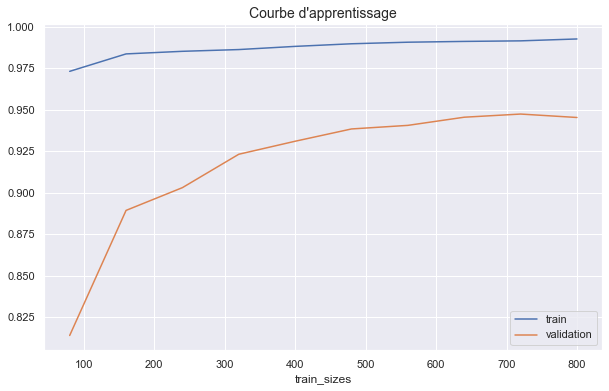

In [232]:
N,train_score,val_score = learning_curve(rfr,X_train,y_train,train_sizes = np.linspace(0.1,1.0,10))
plt.figure(figsize=(10, 6))
plt.plot(N,train_score.mean(axis=1),label='train')
plt.plot(N,val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.title("Courbe d'apprentissage", size = 14)
plt.legend()
plt.show()

#### Courbe de validation du modèle RandomForest

In [233]:
param_range = [50, 100, 150, 200, 250]  
train_scores, test_scores = validation_curve(
    rfr,  
    X_train, y_train,
    param_name="n_estimators",  
    param_range=param_range,
    cv=5,  
    scoring="r2",  
    n_jobs=-1  
)


In [234]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


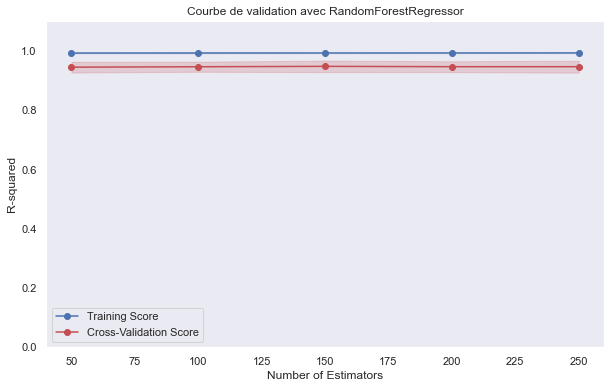

In [235]:
plt.figure(figsize=(10, 6))
plt.title("Courbe de validation avec RandomForestRegressor")
plt.xlabel("Number of Estimators")
plt.ylabel("R-squared")
plt.ylim(0.0, 1.1)
plt.grid()

plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="b")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="r")
plt.plot(param_range, train_scores_mean, 'o-', color="b", label="Training Score")
plt.plot(param_range, test_scores_mean, 'o-', color="r", label="Cross-Validation Score")

plt.legend(loc="best")
plt.show()


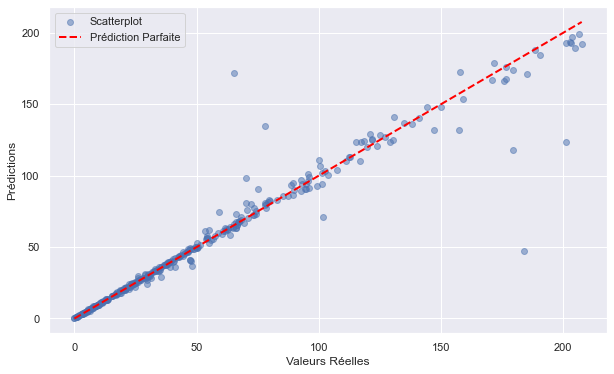

In [236]:
y_pred = rfr.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='b', label='Scatterplot')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--',
         linewidth=2, label='Prédiction Parfaite')
plt.xlabel('Valeurs Réelles')
plt.ylabel('Prédictions')
plt.legend(loc='upper left')

plt.show()


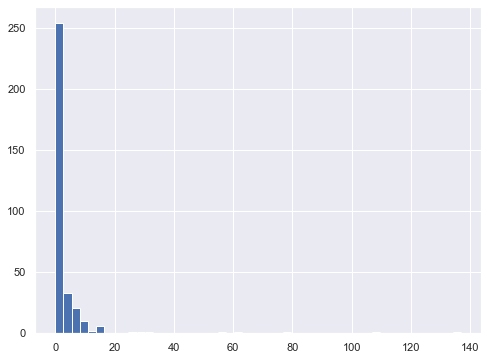

In [237]:
plt.figure(figsize=(8, 6))
y_pred = rfr.predict(X_test)
histo_erreur = np.abs(y_test - y_pred)
plt.hist(histo_erreur, bins= 50)
plt.show()

#### Courbe d'apprentissage du modèle GradientBoost

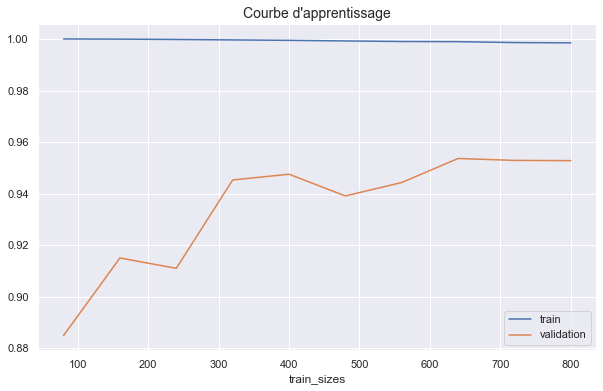

In [238]:
N,train_score,val_score = learning_curve(gboost,X_train,y_train,train_sizes = np.linspace(0.1,1.0,10))
plt.figure(figsize=(10, 6))
plt.plot(N,train_score.mean(axis=1),label='train')
plt.plot(N,val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.title("Courbe d'apprentissage", size = 14)
plt.legend()
plt.show()

#### Courbe de validation du modèle GradientBoost

In [239]:
param_range = [50, 100, 150, 200, 250]  
train_scores, test_scores = validation_curve(
    gboost,  
    X_train, y_train,
    param_name="n_estimators",  
    param_range=param_range,
    cv=5,  
    scoring="r2",  
    n_jobs=-1  
)


In [240]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


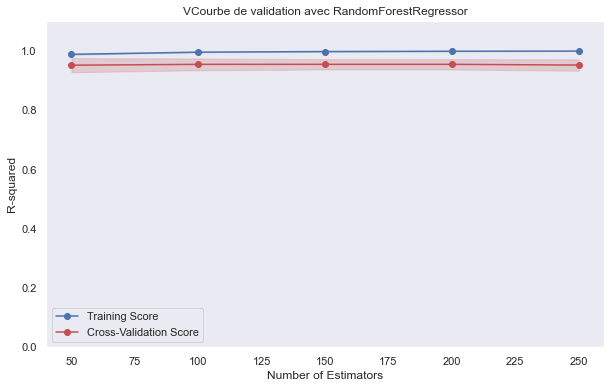

In [241]:
plt.figure(figsize=(10, 6))
plt.title("VCourbe de validation avec RandomForestRegressor")
plt.xlabel("Number of Estimators")
plt.ylabel("R-squared")
plt.ylim(0.0, 1.1)
plt.grid()

plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="b")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="r")
plt.plot(param_range, train_scores_mean, 'o-', color="b", label="Training Score")
plt.plot(param_range, test_scores_mean, 'o-', color="r", label="Cross-Validation Score")

plt.legend(loc="best")
plt.show()


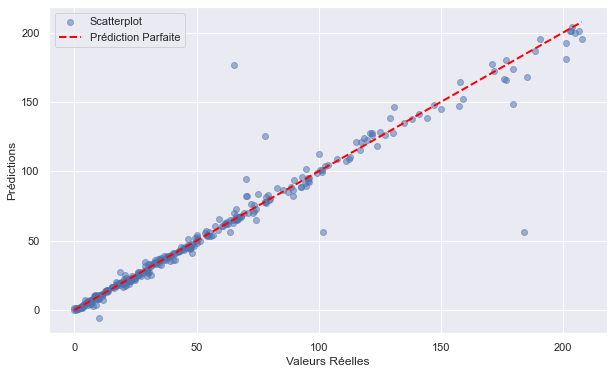

In [242]:
y_pred = gboost.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='b', label='Scatterplot')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--',
         linewidth=2, label='Prédiction Parfaite')
plt.xlabel('Valeurs Réelles')
plt.ylabel('Prédictions')
plt.legend(loc='upper left')

plt.show()


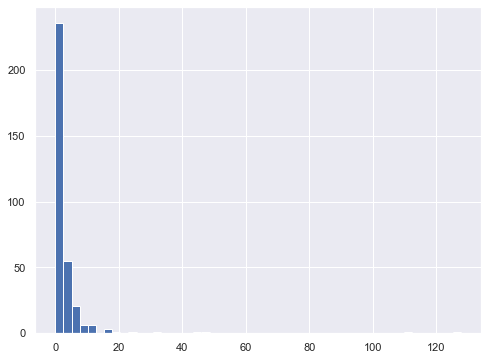

In [243]:
plt.figure(figsize=(8, 6))
y_pred = gboost.predict(X_test)
histo_erreur = np.abs(y_test - y_pred)
plt.hist(histo_erreur, bins= 50)
plt.show()